In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121,EfficientNetB6


2024-03-18 21:08:06.559318: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 21:08:06.559426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 21:08:06.695194: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMAGE_SIZE= 112
BATCH_SIZE= 32

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/melanoma-cancer-dataset/train",
    shuffle=True,
    seed=123,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 11879 files belonging to 2 classes.


In [4]:
dataset.class_names

['Benign', 'Malignant']

In [5]:
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/melanoma-cancer-dataset/test",
    shuffle=False,
    seed=123,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 2000 files belonging to 2 classes.


In [6]:
test_set.class_names

['Benign', 'Malignant']

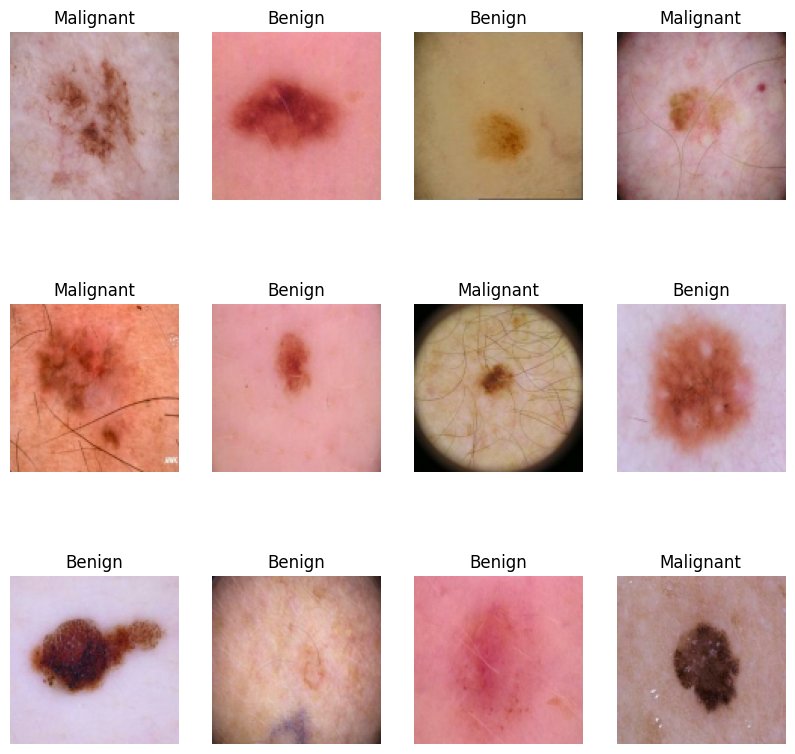

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(test_set.class_names[label_batch[i]])

In [8]:
def train_val_split(dataset, train_split=0.8, valid_split=0.2, shuffle= True, shuffle_size=10000):
    ds_size=len(dataset)
    if shuffle:
        ds=dataset.shuffle(shuffle_size,seed=12)
    train_size=int(ds_size*train_split)
    valid_size=int(ds_size*valid_split)
    valid_ds= ds.skip(train_size).take(valid_size)
    train_ds=ds.take(train_size)
    return train_ds, valid_ds

In [9]:
train_ds, val_ds = train_val_split(dataset, train_split=0.8, valid_split=0.2, shuffle= True)

In [10]:
def count_class(dataset):
    contagem_classes = {}
    for imagens, rotulos in train_ds:
        for rotulo in rotulos.numpy():
            if rotulo in contagem_classes:
                contagem_classes[rotulo] += 1
            else:
                contagem_classes[rotulo] = 1

    for classe, contagem in contagem_classes.items():
        print(f"Class {classe}: {contagem} samples")

In [11]:
count_class(train_ds)

Class 0: 4979 samples
Class 1: 4500 samples


In [12]:
import numpy as np

In [13]:
def classification_model(num_classes, input_shape):
    return tf.keras.Sequential([
            tf.keras.layers.Rescaling(1./255),
            tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.RandomRotation(0.3),
             tf.keras.applications.EfficientNetB7(input_shape= input_shape, include_top=False, weights='imagenet'),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(num_classes, activation='softmax')
    ])


In [14]:
model = classification_model(2, (112, 112, 3))
model.summary()

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ ?                      │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 63,786,960 (243.33 MB)

 Non-trainable params: 310,727 (1.19 MB)

In [15]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set=test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=15,
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)


In [18]:
reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=1,
    mode="auto",
    min_delta=0.00001,
    cooldown=0,
    min_lr=0.0,
)

In [19]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    callbacks=[early_stop, reduce]
)

Epoch 1/50


2024-03-18 21:10:58.107478: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/efficientnetb7_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


297/297 ━━━━━━━━━━━━━━━━━━━━ 297s 518ms/step - accuracy: 0.8164 - loss: 0.4417 - val_accuracy: 0.5215 - val_loss: 2.3903 - learning_rate: 0.0010
Epoch 2/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 138s 464ms/step - accuracy: 0.8852 - loss: 0.2705 - val_accuracy: 0.5891 - val_loss: 1.2917 - learning_rate: 0.0010
Epoch 3/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 138s 464ms/step - accuracy: 0.8985 - loss: 0.2423 - val_accuracy: 0.7855 - val_loss: 0.4681 - learning_rate: 0.0010
Epoch 4/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 138s 464ms/step - accuracy: 0.9043 - loss: 0.2353 - val_accuracy: 0.8902 - val_loss: 0.2690 - learning_rate: 0.0010
Epoch 5/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 138s 464ms/step - accuracy: 0.9112 - loss: 0.2105 - val_accuracy: 0.8961 - val_loss: 0.2441 - learning_rate: 0.0010
Epoch 6/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 137s 461ms/step - accuracy: 0.9200 - loss: 0.1880 - val_accuracy: 0.8999 - val_loss: 0.2460 - learning_rate: 0.0010
Epoch 7/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 137s 462ms/step - accuracy: 0.9202 

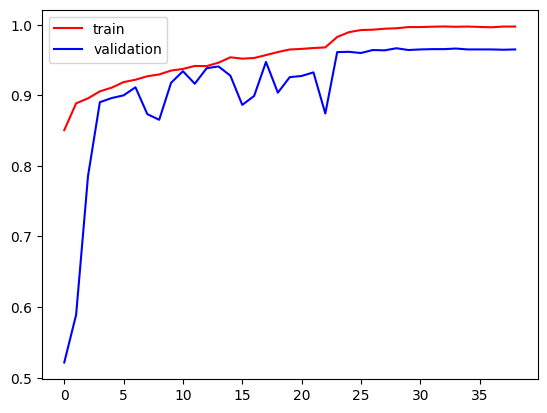

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

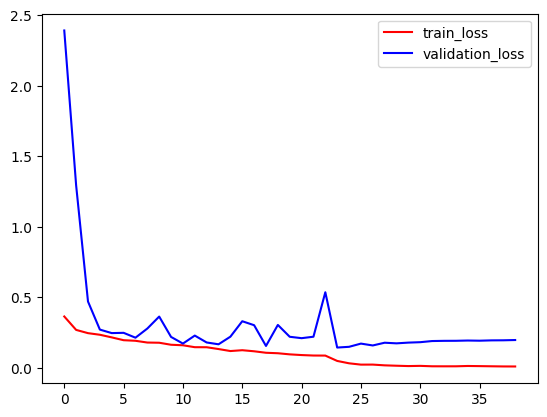

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],color='red',label='train_loss')
plt.plot(history.history['val_loss'],color='blue',label='validation_loss')
plt.legend()
plt.show()

In [22]:
scores=model.evaluate(test_set)

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.9249 - loss: 0.2326


In [23]:
class_names = ['Benign', 'Malignant']

first image to predict
actual label: Malignant
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
predicted label: Malignant


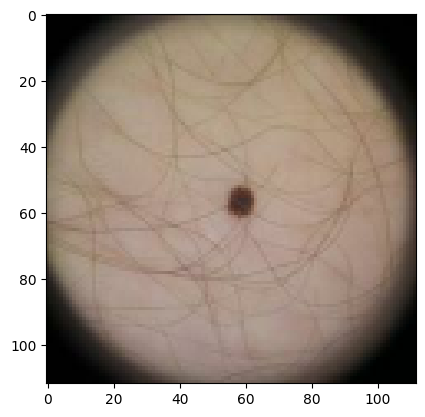

In [24]:
import numpy as np
for images_batch, labels_batch in test_set.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence